In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

In [11]:
GT=np.load('AuxData/Ti7FFT.npy')
# row content
# 0  dilation
# 1  E11
# 2  E12
# 3  E13
# 4  E22
# 5  E23
# 6  E33
# 7  Grain ID
# 8  Phi1
# 9  Psi
# 10 Phi2

In [49]:
np.unique(GT[7].astype('int'))[13]

47

In [64]:
np.unique(GT[7].astype('int'))

array([  2,   5,   8,  13,  15,  17,  18,  20,  26,  28,  32,  34,  38,
        47,  49,  51,  52,  53,  54,  55,  57,  59,  60,  61,  62,  64,
        69,  71,  73,  76,  78,  81,  85,  93,  95,  96,  97, 102, 106,
       107, 109, 113, 114, 121])

In [61]:
GIDLayer=GT[7].astype('int')

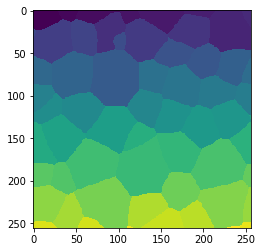

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [84]:
output=-np.ones(GIDLayer.shape,dtype='int')
def floodFill(image,target, sr, sc, newColor):
    """
    :type image: List[List[int]]
    :type sr: int
    :type sc: int
    :type newColor: int
    :rtype: List[List[int]]
    """
    R,C=len(image),len(image[0])
    color=image[sr][sc]
    if target[sr][sc]==newColor: return image
    def dfs(r,c):
        if image[r][c]==color and target[r][c]!=newColor:
            target[r][c]=newColor
            if r>0: dfs(r-1,c)
            if r+1<R: dfs(r+1,c)
            if c>0: dfs(r,c-1)
            if c+1<C: dfs(r,c+1)
    dfs(sr,sc)
    return target

curlabel=0
srs,scs=np.where(output==-1)
while len(srs)>0:
    sr,sc=srs[0],scs[0]
    output=floodFill(GIDLayer,output,sr,sc,curlabel)
    curlabel+=1
    srs,scs=np.where(output==-1)

plt.imshow(output)
plt.show()
np.unique(output)

In [87]:
np.unique(GT[7])

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 35., 36., 37., 38.,
       39., 40., 41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51.,
       52., 53., 54., 55., 56., 57., 58., 59.])

In [88]:
np.save('AuxData/Ti7FFT.npy',GT)

<IPython.core.display.Javascript object>


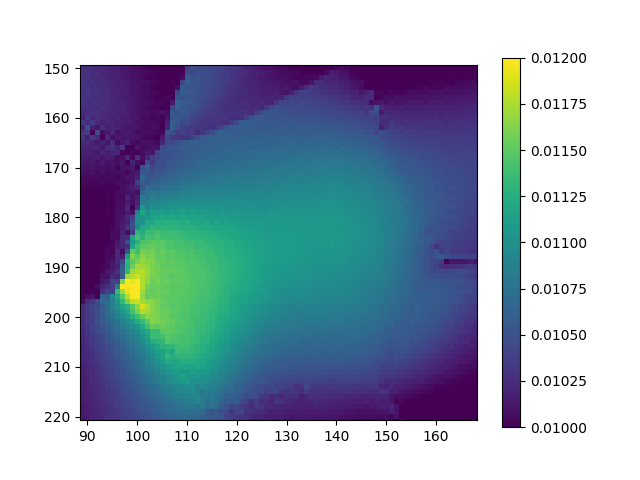

In [16]:
%matplotlib notebook
plt.imshow(GT[6]*20
           ,vmin=0.01,vmax=0.012
          )
plt.colorbar()
plt.show()

<IPython.core.display.Javascript object>


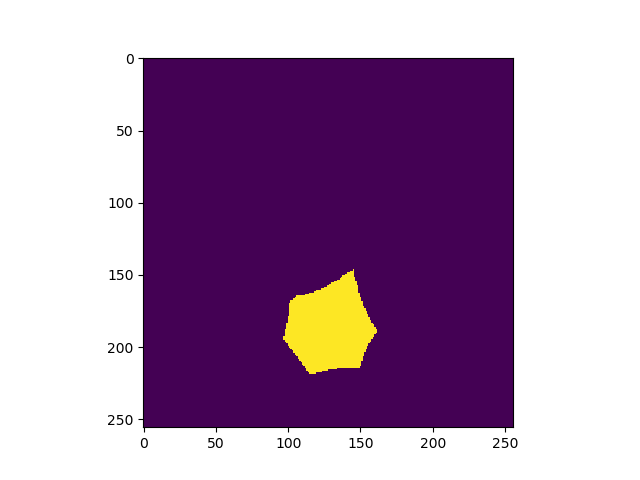

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59])

In [149]:
plt.imshow(output==40)

plt.show()
np.unique(output)

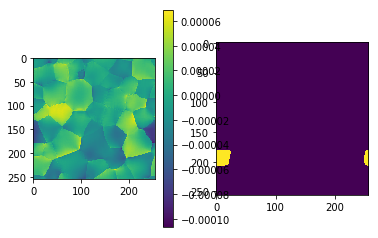

In [60]:
fig,axs=plt.subplots(1,2)
tmp=axs[0].imshow(GT[2])
fig.colorbar(tmp,ax=axs[0])
tmp=axs[1].imshow(GT[7]==47)
plt.show()

In [2]:
a=h5py.File('../SimData/grain_40.hdf5','r')

In [139]:
a['limits'][51]

array([ 949, 1249,  129,  289, 2430])

In [140]:
a['MaxInt'].dtype

dtype('<f8')

In [6]:
tmp=np.array(a['Imgs']['Im2'])
print(np.max(tmp))
np.where(tmp==np.max(tmp))

267


(array([65, 65, 65]), array([123, 124, 125]), array([18, 18, 18]))

<IPython.core.display.Javascript object>


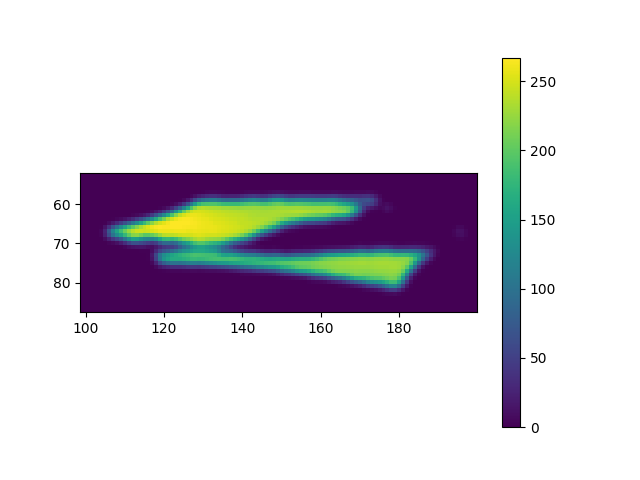

In [13]:
%matplotlib notebook
plt.imshow(a['Imgs']['Im2'][:,:,18])
plt.colorbar()
plt.show()

In [120]:
(a['Imgs']['Im0']).shape

(160, 300, 45)

In [141]:
b=h5py.File('../workspace/Exp_G13_Ps1_2nd.hdf5','r')

In [142]:
b['MaxInt'][:]

array([   5,   18,    6,   16,    6,   11,   16,    8,   35,   39,   23,
         14,   56,   38,   76,  173,   45,   49,   10,   15,   44,   71,
         61,   63,   36,   34,   11,   17,   63,   18,   34,    9,   88,
        237,   52,   65,   34,  159,   77,  288,  281,   57,   68,   90,
         17,   30,  110,   49,  141,   36,   41,   85,   61,   30,  187,
         44,   82,   16,  135,   84,  423, 1150,  131,  166,   30,  407,
        977,  525,  146,   79,  313,  138,  359,   98,   60,  134,   38,
        404, 1089,  533,  151,  485,  292, 1822, 2432, 2571,  353,  361,
         72,  568,  225, 1930,  697, 1757, 2156,  157,  250,  474,  508,
        187,  427,  101, 1113, 1951,  394,  528, 2393,  408], dtype=uint16)

In [36]:
np.moveaxis(b,0,2).shape

(160, 300, 45)

In [143]:
a.close()